# EffectModels

In this tutorial we look at how a user can add effects to our objects to make their sampled flux more realistic.

TDAstro supports multiple source-level effects including:
  * Constant dimming
  * Dust extinction
  * White Noise

In addition, as shown below, users can create their own effects.


## Applying Effects 

We add effects to our objects, using the `PhysicalModel.add_effect()` function, before generating samples. For example if we want to apply a basic white noise effect to a static source we would use

In [1]:
import numpy as np

from tdastro.effects.white_noise import WhiteNoise
from tdastro.sources.basic_sources import StaticSource

# Create the static source model with the white noise effect.
model = StaticSource(
    brightness=10.0,
    node_label="my_static_source",
    seed=100,
)

# Create the white noise effect.
white_noise = WhiteNoise(white_noise_sigma=0.1)
model.add_effect(white_noise)

# Sample the flux.
state = model.sample_parameters()
times = np.array([1, 2, 3, 4, 5, 10])
wavelengths = np.array([100.0, 200.0, 300.0])
model.evaluate(times, wavelengths, state)

array([[ 9.94745694,  9.92491398, 10.0599079 ],
       [ 9.96875996,  9.89920816,  9.86939942],
       [ 9.93163288, 10.00177445, 10.00417478],
       [10.08032484,  9.7189909 ,  9.93380431],
       [ 9.98207824, 10.0376998 , 10.00321988],
       [10.07121523,  9.91733376, 10.01863068]])

## Dust Maps

Dust extinction represents a more complex effect since it requires the user to specify both a dust map and an extinction function. The dust map is stored in a `ParameterizedNode` that uses the source's (RA, dec) to compute ebv values. The `ExtinctionEffect` then links these together by creating a new "ebv" parameter in the source node. This "ebv" parameter is the output of the dustmap and the input to the extinction event.

In [2]:
from tdastro.astro_utils.dustmap import ConstantHemisphereDustMap, DustmapWrapper
from tdastro.effects.extinction import ExtinctionEffect

model2 = StaticSource(
    brightness=100.0,
    ra=45.0,
    dec=20.0,
    redshift=0.0,
    node_label="source",
)

# Create a dust map that pulls ebv values using the source's (RA, dec) values.
dust_map = ConstantHemisphereDustMap(north_ebv=0.8, south_ebv=0.5)
dust_map_node = DustmapWrapper(
    dust_map,
    ra=model2.ra,
    dec=model2.dec,
    node_label="dust_map",
)

# Create an add an extinction effect.
ext_effect = ExtinctionEffect(extinction_model="CCM89", ebv=dust_map_node, Rv=3.1)
model2.add_effect(ext_effect)

# Sample the model.
times = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
wavelengths = np.array([7000.0, 5200.0])
states2 = model2.sample_parameters(num_samples=3)
model2.evaluate(times, wavelengths, states2)

array([[[18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139]],

       [[18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139]],

       [[18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139],
        [18.0230379 ,  8.72173139]]])

By printing the information in the `states` variable, we can see a sampled ebv for each different model (RA, dec).

In [ ]:
print(states2)

Most users will want to use a more realistic dust map, such as those from the `dustmaps` library. For example if you had that package installed, you could create the dust map node as:

```
from dustmaps.config import config as dm_config
import dustmaps.sfd

from tdastro.astro_utils.dustmap import DustmapWrapper

dm_config["data_dir"] = "../../data/dustmaps"
dustmaps.sfd.fetch()
dust_map_node = DustmapWrapper(dustmaps.sfd.SFDQuery())
```

## Custom Effects

Users can also create their own custom effect by inheriting from the `EffectModel` class and overriding the `apply()` function. 

An `EffectModel` object can have its own parameters (defined with a `add_effect_parameter()` function). Unlike a `ParameterizedNode`, these parameters will be added to the source object and passed to the effect as input. This means that all effect parameters will be computed during the parameter sampling phase, which keeps them consistent with the model parameters. These parameters *must* also be listed in the argument list for the `apply()` function because that is how the effect will get them.

Let’s consider the example of an effect that adds sinusoidal dimming to the flux.

In [3]:
from tdastro.effects.effect_model import EffectModel


class SinDimming(EffectModel):
    """A sinusoidal dimming model.

    Attributes
    ----------
    period : parameter
        The period of the sinusoidal dimming.
    """

    def __init__(self, period, **kwargs):
        super().__init__(**kwargs)
        self.add_effect_parameter("period", period)

    def apply(
        self,
        flux_density,
        times=None,
        wavelengths=None,
        period=None,
        rng_info=None,
        **kwargs,
    ):
        """Apply the effect to observations (flux_density values).

        Parameters
        ----------
        flux_density : numpy.ndarray
            A length T X N matrix of flux density values (in nJy).
        times : numpy.ndarray, optional
            A length T array of times (in MJD). Not used for this effect.
        wavelengths : numpy.ndarray, optional
            A length N array of wavelengths (in angstroms). Not used for this effect.
        period : float, optional
            The period of the dimming. Raises an error if None is provided.
        rng_info : numpy.random._generator.Generator, optional
            A given numpy random number generator to use for this computation. If not
            provided, the function uses the node's random number generator.
        **kwargs : `dict`, optional
           Any additional keyword arguments. This includes all of the
           parameters needed to apply the effect.

        Returns
        -------
        flux_density : numpy.ndarray
            A length T x N matrix of flux densities after the effect is applied (in nJy).
        """
        if period is None:
            raise ValueError("period must be provided")

        scale = 0.5 * (1.0 + np.sin(2 * np.pi * times / period))
        return flux_density * scale[:, None]

Text(0, 0.5, 'Flux Density (nJy)')

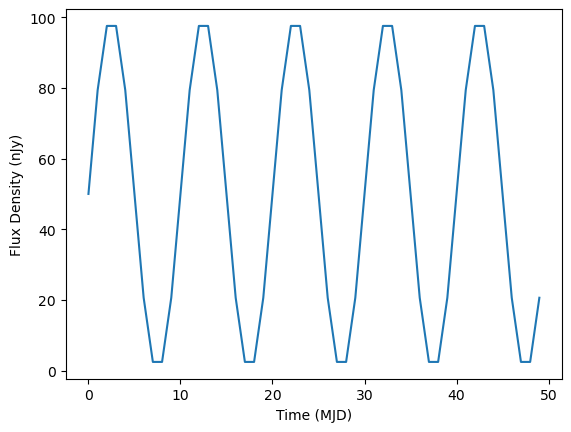

In [4]:
import matplotlib.pyplot as plt

model3 = StaticSource(
    brightness=100.0,
    ra=45.0,
    dec=20.0,
    redshift=0.0,
    node_label="source",
)
sin_effect = SinDimming(period=10.0)
model3.add_effect(sin_effect)

# Construct one same of the model and its output flux.
times = np.arange(50.0)
wavelengths = np.array([7000.0, 5200.0])
fluxes = model3.evaluate(times, wavelengths)

plt.plot(times, fluxes[:, 0])
plt.xlabel("Time (MJD)")
plt.ylabel("Flux Density (nJy)")